# OLX Use Case Challenge
## Time series analysis and forecasting

#### 1 - Load packages and datasets

In [32]:
# Python packages
import pandas as pd
from pandas.plotting import lag_plot, autocorrelation_plot
from datetime import date, timedelta, datetime
from sklearn.metrics import mean_absolute_error
from fbprophet import Prophet
from sklearn.ensemble import RandomForestRegressor
import warnings
import matplotlib.pyplot as plt

# Other options
warnings.filterwarnings(action='ignore')
%matplotlib inline
pd.set_option("display.max_rows", 0)
pd.set_option("display.max_columns", 0)

In [2]:
data1 = pd.read_csv('C:/Users/BF-MSTR/OLX Case study/datasets/data1.csv', header=None, names=['value'])
print(data1.shape)
data2 = pd.read_csv('C:/Users/BF-MSTR/OLX Case study/datasets/data2.csv', header=None, names=['value'])
print(data2.shape)
data3 = pd.read_csv('C:/Users/BF-MSTR/OLX Case study/datasets/data3.csv')
print(data3.shape)

(5001, 1)
(4171, 1)
(762678, 61)


*Exploration notes:*
<br> - Dataset 1 is a univariate series which looks to be artificially created, like a signal.
<br> - Dataset 2 is a univariate series, but maybe not artificially created.
<br> - Dataset 3 actually contains multiple series (bond_ids), with variable lenghts (some really long with multiple years, some really small). It also multivariate, as it has a few other columns.
<br>*Decisions and Assumptions:*
<br> - There are no time or date columns, will assume all are daily series. Artificial dates will be generated.
<br> - In dataset 3, there is a huge amount of individual series. For the sake of this challenge, there won't be enough time to analyse all series - only a few of the biggest series (the ones with more data) will be analysed.
<br> - It is a good practice to try a range of models to check which one better fits to the data. 
<br> - But, because of limited time, only two will be used - Prophet (opensourced by Facebook) and RandomForest (for the third dataset).

#### 2 - Define helper functions
These implements useful steps like adding fake dates to the datasets, split in train and test datasets, train a prophet model and calculate Mean Absolute Error, and so on.

In [3]:
def add_dates_to_timeseries(timeseries):
    timeseries = timeseries.reset_index(drop=True)
    end_date = datetime.strptime('2018-12-31', '%Y-%m-%d')# date.today()
    series_size = timeseries.shape[0]
    start_date = end_date - timedelta(days=series_size-1)
    date_rng = pd.DataFrame(pd.date_range(start=start_date, end=end_date, freq='D'))
    df = pd.concat([date_rng,timeseries],axis=1)
    df.columns = ['ds','y']
    df = df.set_index('ds')
    return df

In [4]:
def timeseries_split(dated_timeseries,test_perc=0.25):
    min_date = min(dated_timeseries.index)
    max_date = max(dated_timeseries.index)
    series_size = len(dated_timeseries)
    days_to_train = round(series_size*test_perc)
    train_end_date = max_date - (timedelta(days=days_to_train-1))
    test_start_date = train_end_date + (timedelta(days=1))
    train = dated_timeseries[min(dated_timeseries.index):train_end_date]
    test = dated_timeseries[test_start_date:max(dated_timeseries.index)]                 
    return train, test

In [5]:
def timeseries_to_prophet(timeseries):
    prophet_timeseries = pd.concat([(pd.Series(timeseries.index)),pd.Series(timeseries['y'].values).rename('y')],axis=1)
    return prophet_timeseries

In [6]:
def train_prophet(timeseries,plot=1):
    # Add dates and split into train/test
    timeseries = add_dates_to_timeseries(timeseries)
    train,test = timeseries_split(timeseries)
    train = timeseries_to_prophet(train)
    test  = timeseries_to_prophet(test)
    
    #Train model
    m = Prophet()
    m.fit(train)
    
    #Predict on test data
    test_pred = m.predict(pd.DataFrame(test['ds']))
    if plot == 1:
        m.plot(test_pred, uncertainty=True)
        m.plot_components(test_pred)
    test_pred['y_true'] = test['y']
    
    # Calculate Mean Absolute Error and print
    mae = mean_absolute_error(test_pred[['y_true']], test_pred[['yhat']])
    print('MAE = ', mae)
    
    return test_pred

In [45]:
def plot_two_series(actual, predicted):    
    actual = pd.DataFrame(add_dates_to_timeseries(actual))
    predicted = pd.DataFrame(predicted,index=actual.index)
    
    actual_vs_predicted_df = pd.concat([actual,predicted],axis=1)
    actual_vs_predicted_df.columns = ['Actual','Predicted']
    actual_vs_predicted_df.plot(title='Actual vs Predicted', marker='.',alpha=0.3,figsize=(6.5, 4))
    plt.show()

In [92]:
def train_rf(multivariate_timeseries): # Only used for multivariate, like dataset 3
    # Add fake date 
    multivariate_timeseries = multivariate_timeseries.reset_index(drop=True)
    end_date = datetime.strptime('2018-12-31', '%Y-%m-%d')# date.today()
    series_size = multivariate_timeseries.shape[0]
    start_date = end_date - timedelta(days=series_size-1)
    date_rng = pd.DataFrame(pd.date_range(start=start_date, end=end_date, freq='D'))

    multivariate_timeseries = pd.concat([date_rng,multivariate_timeseries],axis=1)
    multivariate_timeseries = multivariate_timeseries.rename(columns={ multivariate_timeseries.columns[0]: "ds" })
    multivariate_timeseries = multivariate_timeseries.set_index('ds')
    
    # Add datetime features
    multivariate_timeseries['Year'] = multivariate_timeseries.index.year
    multivariate_timeseries['Month'] = multivariate_timeseries.index.month
    multivariate_timeseries['Day'] = multivariate_timeseries.index.day
    multivariate_timeseries['Weekday'] = multivariate_timeseries.index.weekday
    #multivariate_timeseries['Weekday Name'] = multivariate_timeseries.index.weekday_name
    
    # Split into train and test
    columns_to_drop = ['id','bond_id']
    multivariate_timeseries.drop(columns_to_drop,axis=1,inplace=True)
    train_size = round(len(multivariate_timeseries)*0.75)
    train, test = multivariate_timeseries[0:train_size], multivariate_timeseries[train_size:]
    
    train = train.dropna()
    test = test.dropna()
    
    #print(train.loc[:, train.columns != 'trade_price'].columns)
    X_train = train.loc[:, train.columns != 'trade_price']
    y_train = train.loc[:, train.columns == 'trade_price']
    X_test = test.loc[:, test.columns != 'trade_price']
    y_test = test.loc[:, test.columns == 'trade_price']
    
    # Train RF Regresor
    rf = RandomForestRegressor(n_estimators = 50, random_state = 42)
    rf.fit(X_train, y_train)
    
    # Predict test data
    test_predictions = rf.predict(X_test)
    mae = mean_absolute_error(y_test, test_predictions)
    print('MAE = ', mae)
    
    plot_two_series(test.loc[:, test.columns == 'trade_price'], test_predictions)
    
    # Feature importance
    top_n = 10
    feature_importances = pd.DataFrame(rf.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance',ascending=False).head(top_n).sort_values(by='importance',ascending=True)
    feature_importances.plot.barh() 
    plt.show()
    
    #return rf

# 3 - Time series analysis and forecasting
## 3.1 Dataset 1 (data1.csv)

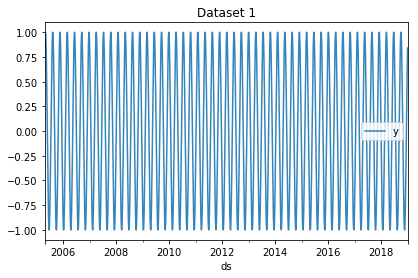

In [9]:
data1_df = add_dates_to_timeseries(data1)
data1_df.plot(alpha=0.9,figsize=(6.5, 4),title='Dataset 1')

This series looks like a signal, so let's test it with an autocorrelation plot. It can be seen that it is not too random, as many high correlations can be found at different lag steps.
<br> A lag plot also helps showing the absence of randomness.

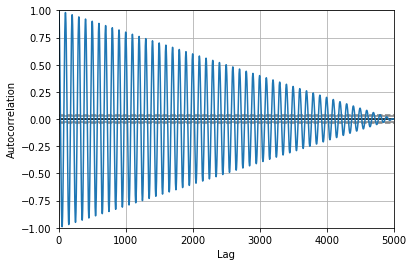

In [10]:
autocorrelation_plot(data1_df)

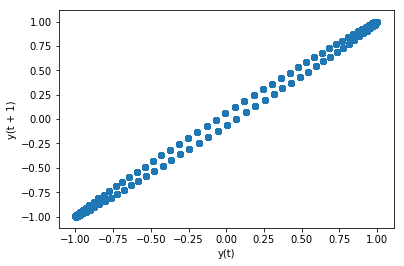

In [11]:
lag_plot(data1_df)

Let's see how Prophet fits this data.
<br> It can be seen in the first plot that the model didn't fit very well while using standard parameters (predictions in blue). That is confirmed by the relatively high MAE. 
<br> As next steps, different models could be tried as well as trying to tweak Prophet's hyperparameters.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE =  0.6468670249595282


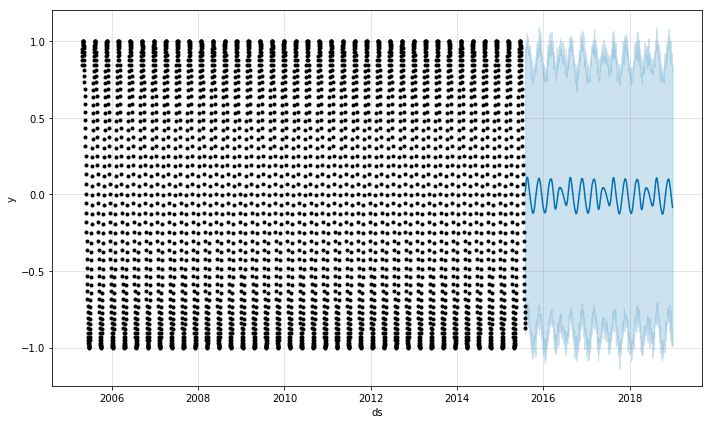

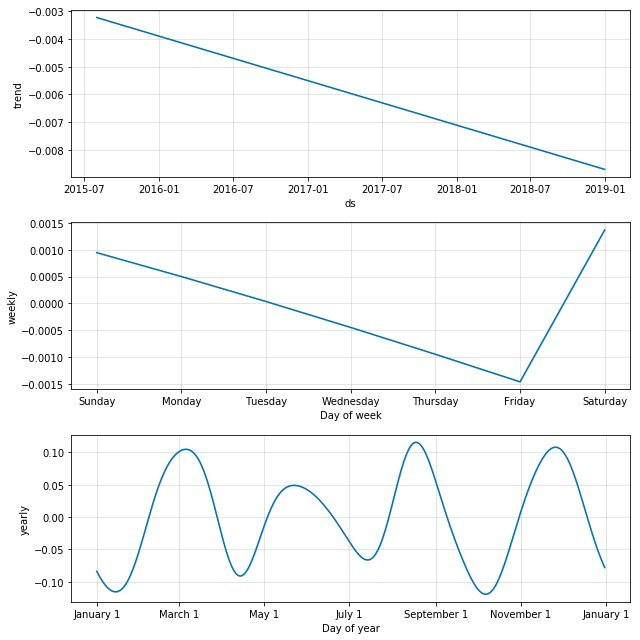

In [12]:
model1 = train_prophet(data1)

## 3.2 Dataset 2 (data2.csv)

Let's see how this series looks. It can resemble a stock price series or something like that.

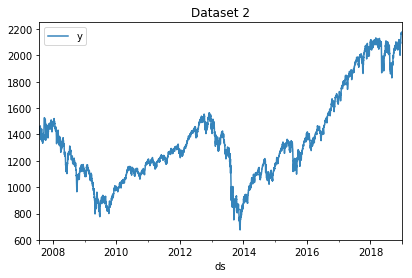

In [107]:
data2_df = add_dates_to_timeseries(data2)
data2_df.plot(alpha=0.9,figsize=(6.5, 4),title='Dataset 2')

Let's check its randomness through autocorrelation and lag plots.
<br> Yes, it doesn't look to be synthetic as some valleys can clearly be spotted.

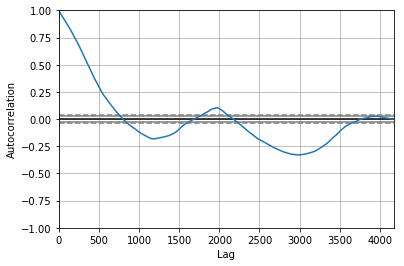

In [14]:
autocorrelation_plot(data2_df)

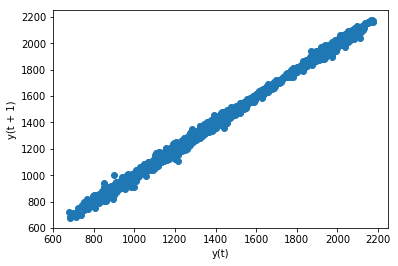

In [15]:
lag_plot(data2_df)

By looking at the running sum plot with an yearly window below, we can see some periodic behaviors where there are lows in 2010 and 2014, with a steady growing trend after 2014.

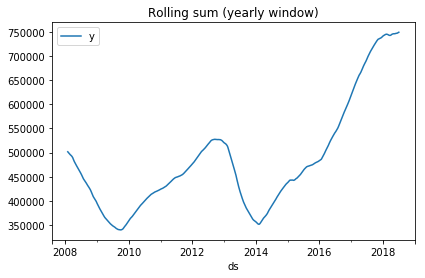

In [48]:
data2_df.rolling(window=365,center=True).sum().plot(title = 'Rolling sum (yearly window)',figsize=(6.5, 4))

Let's use Prophet to fit this dataset.
<br> The MAE of 256 is not so bad, as well as the first few forecast timesteps - they have a reasonably tight confidence intervals, which become worse as it tries to predict more into the future.
<br> Weekly and yearly trends can be spotted, but their influence is not a big deal (look at the y axis, its values are kind of small when compared to the actual scale).

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE =  256.61870671013264


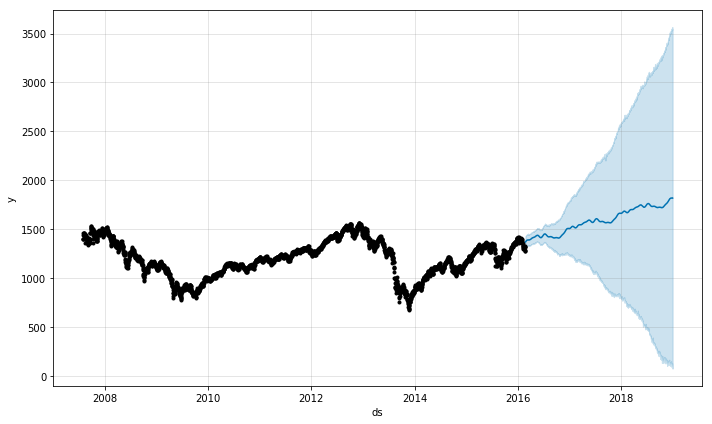

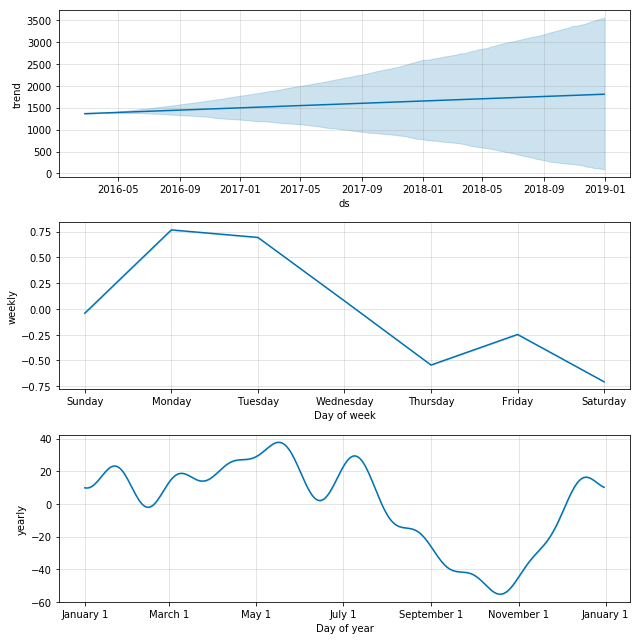

In [17]:
model2 = train_prophet(data2)

## 3.3 Dataset 3 (data3.csv)

In [103]:
# How many distinct bonds are there
print('There are ' + str(data3['bond_id'].nunique()) + ' unique bond_ids.' )

# Pick up the bond_ids with longer series
top_x = 3
top_bond_ids = data3.groupby('bond_id').size().sort_values(ascending=False).head(top_x).index
print('These bond_ids are identified containing the highest series sizes: ', list(top_bond_ids))
print('These are the only series to be analyzed for now. With time all series could be analyzed.')

There are 3736 unique bond_ids.
These bond_ids are identified containing the highest series sizes:  [6968, 5595, 17542]
These are the only series to be analyzed for now. With time all series could be analyzed.



============= BOND_ID = 6968 =====================

12129


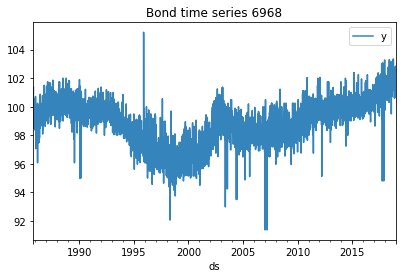

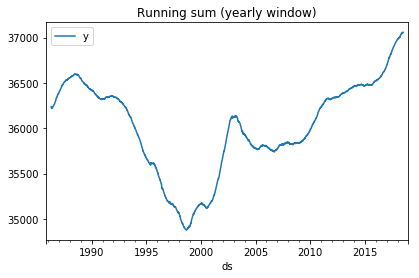

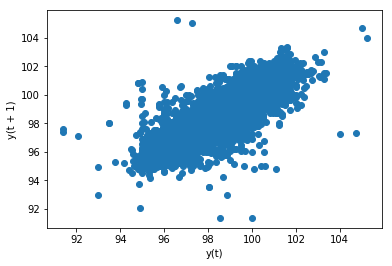

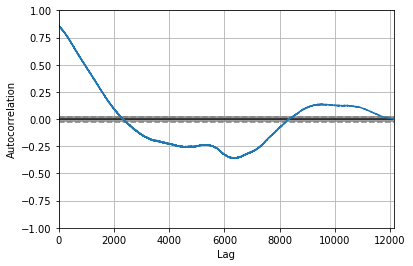


============= BOND_ID = 5595 =====================

7002


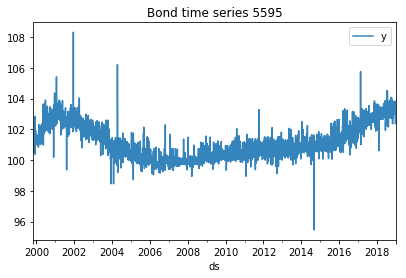

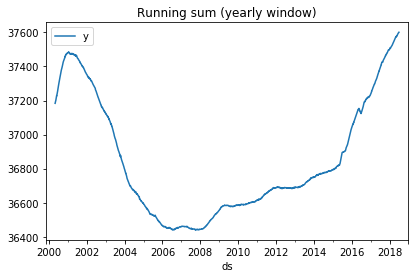

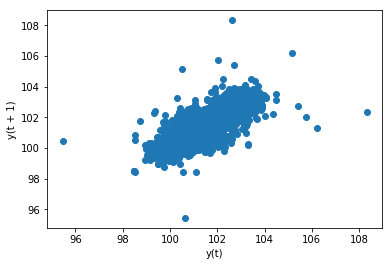

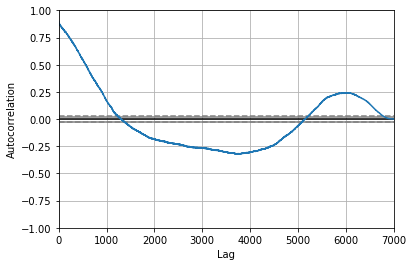


============= BOND_ID = 17542 =====================

6458


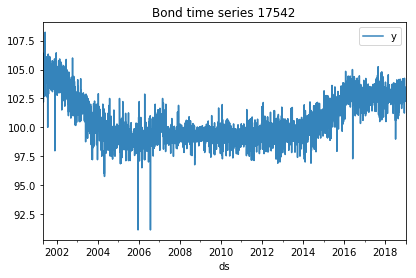

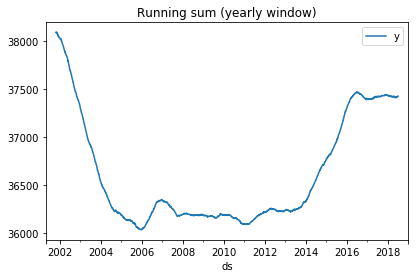

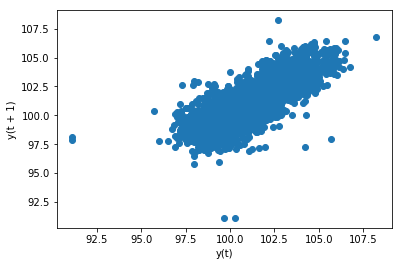

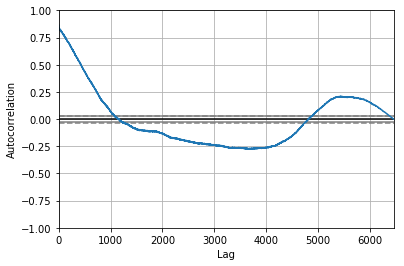

In [113]:
for id in top_bond_ids:
    print('==================================================\n')
    print('============= BOND_ID = ' + str(id) + ' =====================\n')
    timeseries = pd.DataFrame(data3[data3.bond_id == id]['trade_price'])
    timeseries = add_dates_to_timeseries(timeseries)
    print(len(timeseries))
    timeseries.plot(alpha=0.9,figsize=(6.5, 4), title = 'Bond time series ' + str(id))
    plt.show()
    timeseries.rolling(window=365,center=True).sum().plot(title = 'Running sum (yearly window)',figsize=(6.5, 4))
    plt.show()
    lag_plot(timeseries)
    plt.show()
    autocorrelation_plot(timeseries)
    plt.show()

Let's see how Prophet forecast for each of these bond time series. Details like the prediction confidence interval and periodic trends will also be ploted for each series.

============= BOND_ID = 6968 =====================



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE =  0.9936013510900715


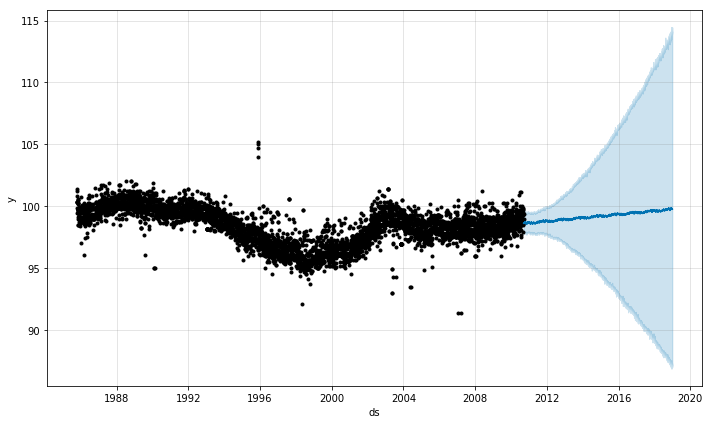

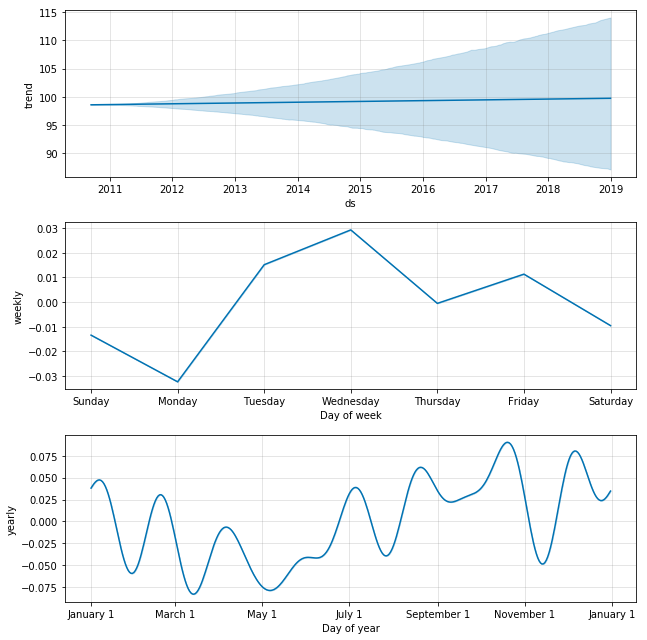

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



============= BOND_ID = 5595 =====================

MAE =  1.0148602217950362


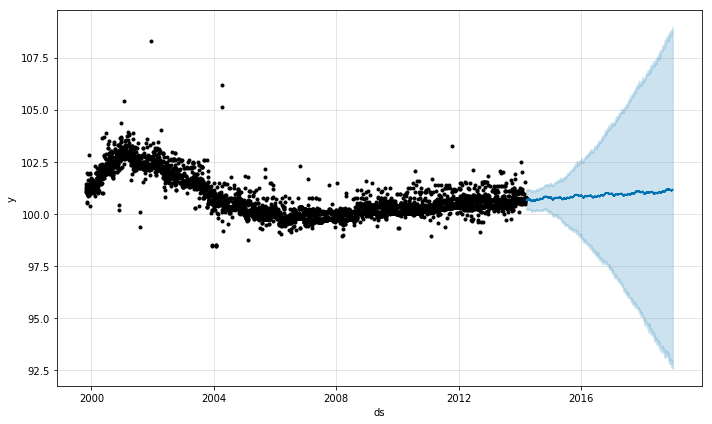

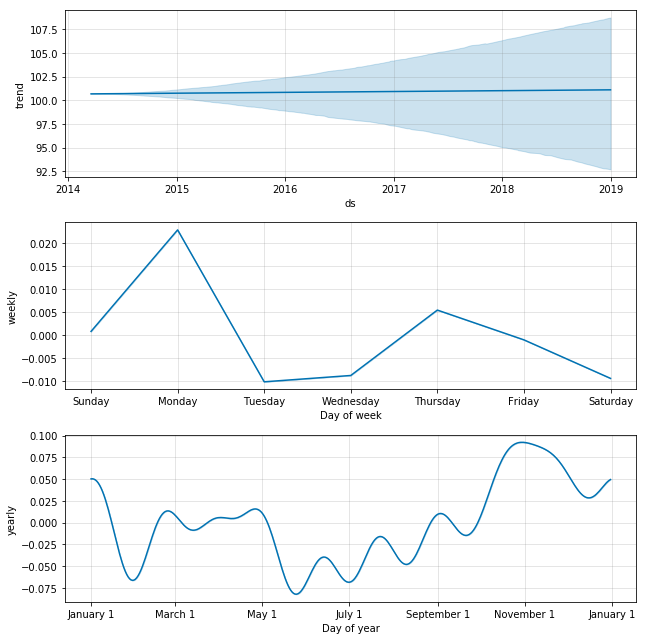

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



============= BOND_ID = 17542 =====================

MAE =  1.946878767148642


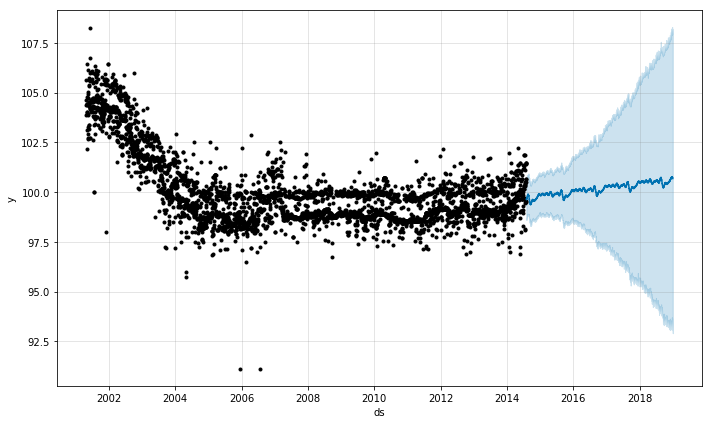

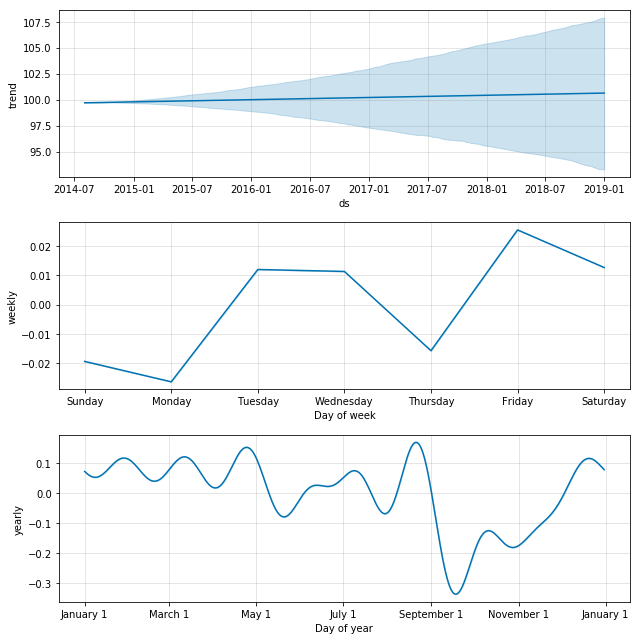

In [105]:
for id in top_bond_ids:
    print('============= BOND_ID = ' + str(id) + ' =====================\n')
    timeseries = data3[data3.bond_id == id]['trade_price']
    train_prophet(timeseries)
    plt.show()
    print('==================================================\n')

Let's try a different approach by turning the multivariate timeseries into a supervised learning approach, by using RandomForest as a regressor.
<br> Surprisingly, this model had better performance compared to Prophet in every tested dataset, also providing a way to understand the important features.
<br> As a next step to this, multivariate-specific time series models should be tested as well as deep learning LSTM.

============= BOND_ID = 6968 =====================

MAE =  0.6442571497165934


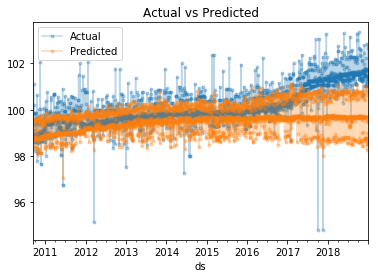

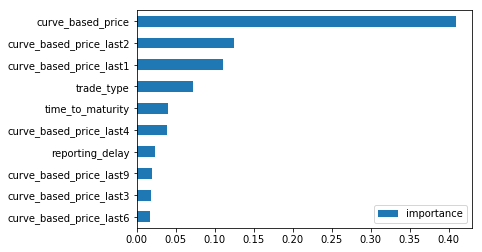


============= BOND_ID = 5595 =====================

MAE =  0.29915064303757427


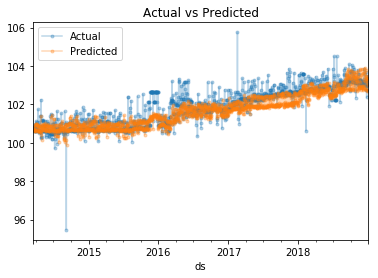

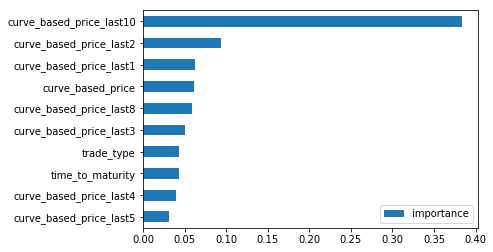


============= BOND_ID = 17542 =====================

MAE =  0.6945208331928957


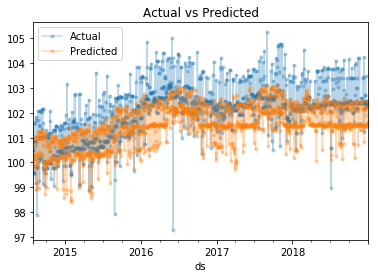

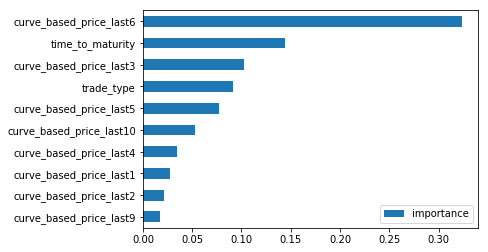

In [106]:
for id in top_bond_ids:
    print('============= BOND_ID = ' + str(id) + ' =====================\n')
    timeseries = data3[data3.bond_id == id]
    train_rf(timeseries)
    plt.show()
    print('==================================================\n')